<a href="https://colab.research.google.com/github/ben-velastegui/dxc-ai-assessment/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from transformers import DistilBertTokenizer, DistilBertModel
from sentence_transformers import SentenceTransformer


# Build encoders for the model's data

Begin with the metrics encoder since metrics are the easiest: they’re already numerical time series.

In [ ]:
# Load metrics
metrics = pd.read_csv("/content/metrics.csv", parse_dates=["now"])
metrics.head()

,now,cpu.user,mem.used,load.cpucore,load.min1,load.min5,load.min15,node
0,2019-11-19 18:38:39,10.8,2.592301e+09,8,1.61,1.73,1.68,wally124_metrics
1,2019-11-19 18:38:39,12.4,2.591961e+09,8,1.61,1.73,1.68,wally124_metrics
2,2019-11-19 18:38:39,20.3,2.598203e+09,8,1.61,1.73,1.68,wally124_metrics
3,2019-11-19 18:38:39,15.0,2.593526e+09,8,1.61,1.73,1.68,wally124_metrics
4,2019-11-19 18:38:40,10.3,2.593448e+09,8,1.61,1.73,1.68,wally124_metrics


In [ ]:
# Normalize the features
## Transformers don’t like raw scales — so normalize cpu, mem, load1.

feature_cols = ["cpu.user", "mem.used", "load.cpucore", "load.min1", "load.min5", "load.min15"]

scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics[feature_cols])

metrics_scaled = pd.DataFrame(metrics_scaled, columns=feature_cols)
metrics_scaled["timestamp"] = metrics["now"].values
metrics_scaled["node"] = metrics["node"].values
metrics_scaled.head()

,cpu.user,mem.used,load.cpucore,load.min1,load.min5,load.min15,timestamp,node
0,-1.119011,-0.517864,0.0,-0.863917,-0.780525,-0.872241,2019-11-19 18:38:39,wally124_metrics
1,-0.849190,-0.517961,0.0,-0.863917,-0.780525,-0.872241,2019-11-19 18:38:39,wally124_metrics
2,0.483052,-0.516169,0.0,-0.863917,-0.780525,-0.872241,2019-11-19 18:38:39,wally124_metrics
3,-0.410731,-0.517512,0.0,-0.863917,-0.780525,-0.872241,2019-11-19 18:38:39,wally124_metrics
4,-1.203330,-0.517534,0.0,-0.863917,-0.780525,-0.872241,2019-11-19 18:38:40,wally124_metrics


# Handle node

	If there are multiple nodes (servers), I can either:
	1.	Train a separate encoder per node, or
	2.	Encode node as an embedding and feed it into the model.

For option 2 (recommended if multi-node):

In [ ]:
# This data has 5 unique nodes
num_nodes = metrics_scaled["node"].nunique()
node_embed = nn.Embedding(num_embeddings=num_nodes, embedding_dim=8)

# Second attempt

In [ ]:


# Load data
metrics = pd.read_csv("/content/metrics.csv", parse_dates=["now"])

# Map node - integer ID
node2id = {node: i for i, node in enumerate(metrics["node"].unique())}
metrics["node_id"] = metrics["node"].map(node2id)

print(node2id)  # mapping of node names to IDs

{'wally124_metrics': 0, 'wally122_metrics': 1, 'wally123_metrics': 2, 'wally113_metrics': 3, 'wally117_metrics': 4}


In [ ]:


feature_cols = ["cpu.user", "mem.used", "load.cpucore", "load.min1", "load.min5", "load.min15"]

scaler = StandardScaler()
metrics[feature_cols] = scaler.fit_transform(metrics[feature_cols])

In [ ]:


def create_windows_with_nodes(df, feature_cols, window_size=60):
    sequences = []
    node_ids = []

    for node, node_df in df.groupby("node"):
        node_df = node_df.sort_values("now")
        data = node_df[feature_cols].values
        nid = node_df["node_id"].iloc[0]

        for i in range(len(data) - window_size + 1):
            seq = data[i : i + window_size]
            sequences.append(seq)
            node_ids.append(nid)

    return np.array(sequences), np.array(node_ids)

metrics_windows, node_ids = create_windows_with_nodes(metrics, feature_cols, window_size=60)

print(metrics_windows.shape)  # (num_samples, 60, 6)
print(node_ids.shape)         # (num_samples,)

(214464, 60, 6)
(214464,)


In [ ]:


class MetricsEncoder(nn.Module):
    def __init__(self, input_dim=6, model_dim=64, num_heads=4, num_layers=2, num_nodes=None, node_embed_dim=8, dropout=0.1):
        super(MetricsEncoder, self).__init__()

        # Project numeric metrics
        self.input_proj = nn.Linear(input_dim, model_dim)

        # Node embedding
        self.node_embed = nn.Embedding(num_embeddings=num_nodes, embedding_dim=node_embed_dim)
        self.node_proj = nn.Linear(node_embed_dim, model_dim)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x, node_ids):
        # x: [batch, seq_len, input_dim]
        # node_ids: [batch]

        # Numeric projection
        x = self.input_proj(x)  # [batch, seq_len, model_dim]

        # Node embedding (broadcasted across sequence length)
        node_emb = self.node_proj(self.node_embed(node_ids))  # [batch, model_dim]
        node_emb = node_emb.unsqueeze(1).expand(-1, x.size(1), -1)  # [batch, seq_len, model_dim]

        # Add node context
        x = x + node_emb

        # Transformer expects [seq_len, batch, model_dim]
        x = x.permute(1, 0, 2)
        out = self.transformer(x)
        out = out.permute(1, 0, 2)

        # Pooling: mean over time
        return out.mean(dim=1)  # [batch, model_dim]

In [ ]:
# Convert to PyTorch tensors
metrics_tensor = torch.tensor(metrics_windows, dtype=torch.float32)
node_tensor = torch.tensor(node_ids, dtype=torch.long)

# Example batch (first 32 sequences)
batch_x = metrics_tensor[:32]    # [32, 60, 6]
batch_nodes = node_tensor[:32]   # [32]

encoder = MetricsEncoder(input_dim=6, num_nodes=len(node2id))
out = encoder(batch_x, batch_nodes)

print(out.shape)  # [32, 64]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


torch.Size([32, 64])


	So far we have setup the metrics encoder.
	I have:
		1.	Node IDs mapped - each node has an integer ID
		2.	Metrics normalized - all numeric features are scaled
		3.	Sequences/windows created - each sample is a (seq_len × num_features) array
		4.	PyTorch MetricsEncoder defined - includes node embeddings and a transformer

So essentially, the “plumbing” is ready, but nothing has been learned yet.


### Sanity check

In [ ]:
print(metrics_windows.shape)  # should be (num_samples, window_size, num_features)
print(node_ids.shape)         # should be (num_samples,)

(214464, 60, 6)
(214464,)


In [ ]:


metrics_tensor = torch.tensor(metrics_windows[:5], dtype=torch.float32)
node_tensor = torch.tensor(node_ids[:5], dtype=torch.long)

encoder = MetricsEncoder(input_dim=6, num_nodes=len(node2id))
out = encoder(metrics_tensor, node_tensor)

print(out.shape)  # should be (batch_size, model_dim), e.g., (5, 64)

torch.Size([5, 64])


In [ ]:
node_emb_weights = encoder.node_embed.weight.detach().numpy()
print(node_emb_weights.shape)  # (num_nodes, node_embed_dim)

(5, 8)


	Output Interpretation
		1.	metrics_windows.shape = (214464, 60, 6)
			•	214,464 sequences/windows
			•	Each sequence is 60 timesteps long
			•	6 features per timestep
		2.	node_ids.shape = (214464,)
			•	Each sequence has exactly one node ID associated with it
			•	Alignment is correct
		3.	Forward pass output: torch.Size([5, 64])
			•	Batch of 5 sequences
			•	Each sequence produces a 64-dimensional embedding from the transformer
			•	This will be your “metrics representation” for downstream tasks
		4.	Node embeddings shape (5, 8)
			•	Each node is embedded in an 8-dimensional space
			•	These are combined with the sequence in the transformer

	•	Sequences are correctly extracted from metrics
	•	Node IDs are properly aligned
	•	Metrics encoder produces output of expected shape
	•	Node embeddings exist and are correctly incorporated


  ## Encode Logs

In [ ]:
logs_filtered = pd.read_csv("/content/logs.csv")
print(logs_filtered.shape)
logs_filtered.head()

(105533, 23)


,_id,_index,_score,_type,Hostname,user_id,project_domain,Timestamp,@timestamp,log_level,...,programname,request_id,python_module,Logger,user_domain,domain_id,http_status,http_method,http_version,http_url
0,AW6E9bVkjbdRMJxglWVX,flog-2019.11.19,1,fluentd,wally113,fef8a3b265194f279c4b48a3986056aa,default,2019-11-19 19:38:43.606,2019-11-19 18:38:43.606,INFO,...,glance-api,c2762a33-c666-41ad-aed9-f42f6a1df3e8,eventlet.wsgi.server,openstack.glance,default,-,NaN,NaN,NaN,NaN
1,AW6E9nCVjbdRMJxglWXw,flog-2019.11.19,1,fluentd,wally113,5dda052ecd6d4d3793c329cdf32e8d1d,default,2019-11-19 19:39:19.405,2019-11-19 18:39:19.405,INFO,...,glance-api,be39b6f8-0fda-4345-838a-5c640ca074d8,eventlet.wsgi.server,openstack.glance,default,-,NaN,NaN,NaN,NaN
2,AW6E9nCVjbdRMJxglWXz,flog-2019.11.19,1,fluentd,wally113,5dda052ecd6d4d3793c329cdf32e8d1d,default,2019-11-19 19:39:21.444,2019-11-19 18:39:21.444,INFO,...,glance-api,71590429-8095-451c-9c79-4f39020b53ec,eventlet.wsgi.server,openstack.glance,default,-,NaN,NaN,NaN,NaN
3,AW6E9nCVjbdRMJxglWX1,flog-2019.11.19,1,fluentd,wally113,3e2c7c3ee67144d2a0de4df61fe26181,default,2019-11-19 19:39:21.473,2019-11-19 18:39:21.473,INFO,...,glance-api,4ffe9759-1406-4824-bece-7d0467a2c3bb,eventlet.wsgi.server,openstack.glance,default,-,NaN,NaN,NaN,NaN
4,AW6E9nCVjbdRMJxglWX_,flog-2019.11.19,1,fluentd,wally113,fc9d0f18e0cd40b7a47469929ee9d0ce,default,2019-11-19 19:39:24.379,2019-11-19 18:39:24.379,INFO,...,glance-api,d770bd9b-b5af-4839-b83e-7e57f72d1aea,eventlet.wsgi.server,openstack.glance,default,-,NaN,NaN,NaN,NaN


In [ ]:
# DistilBERT for efficiency (smaller than BERT)

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")
bert_model.eval()  # disable dropout

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
torch.save(trace_embeddings, "/content/trace_embeddings.pt")
from google.colab import files
files.download("/content/trace_embeddings.pt")   # or .npy

In [ ]:
# Define encoding function with batching
def encode_logs(log_texts, batch_size=64, max_length=128, device='cuda' if torch.cuda.is_available() else 'cpu'):
    bert_model.to(device)
    all_embeddings = []

    for i in tqdm(range(0, len(log_texts), batch_size)):
        batch = log_texts[i:i+batch_size]
        tokens = tokenizer(
            batch,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            outputs = bert_model(**tokens)
            # Mean pooling over sequence length
            pooled = outputs.last_hidden_state.mean(dim=1)  # [batch, hidden_dim]
            all_embeddings.append(pooled.cpu())

    return torch.cat(all_embeddings, dim=0)

In [ ]:
# Encode all logs
# You now have a fixed-size 768-dimensional vector per log entry.
log_texts = logs_filtered['Payload'].astype(str).tolist()
log_embeddings = encode_logs(log_texts, batch_size=64)
print(log_embeddings.shape)  # e.g., [num_logs, 768]

  3%|▎         | 50/1649 [11:23<6:04:10, 13.66s/it]


KeyboardInterrupt: 

In [ ]:
# Install sentence-transformers if not already


# Load logs
logs_df = pd.read_csv("/content/logs.csv")
print(f"Number of logs: {len(logs_df)}")

# Select text to encode
# You can use 'Payload', or combine multiple fields if needed
logs_texts = logs_df['Payload'].fillna('').astype(str).tolist()

# Initialize model
# all-MiniLM-L6-v2 is small, fast, and gives 384-dim embeddings
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print(f"Using device: {device}")

# Encode in batches
batch_size = 256
embeddings = []

for i in tqdm(range(0, len(logs_texts), batch_size), desc="Encoding logs"):
    batch = logs_texts[i:i+batch_size]
    emb = model.encode(batch, convert_to_tensor=True, show_progress_bar=False)
    embeddings.append(emb)

# Stack all embeddings
log_embeddings = torch.vstack(embeddings)
print(f"Log embeddings shape: {log_embeddings.shape}")

# Save embeddings for later use
torch.save(log_embeddings, "/content/log_embeddings.pt")
print("Saved embeddings to /content/log_embeddings.pt")

Number of logs: 105533


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using device: cpu


Encoding logs: 100%|██████████| 413/413 [1:01:06<00:00,  8.88s/it]


Log embeddings shape: torch.Size([105533, 384])
Saved embeddings to /content/log_embeddings.pt


## Encode traces

In [ ]:
# Load CSV robustly
traces_file = "/content/traces.csv"

traces = pd.read_csv(
    traces_file,
    engine='python',       # more tolerant parser
    on_bad_lines='skip',   # skip malformed lines
    quotechar='"'
)

print(f"Traces shape: {traces.shape}")
print(traces.head())

Traces shape: (872396, 10)
       Host        Name        Service   Project                   Timestamp  \
0  wally113   wsgi-stop         public  keystone  2019-11-20 00:04:53.900608   
1  wally113  wsgi-start         public  keystone  2019-11-20 00:04:53.898661   
2  wally113   wsgi-stop         public  keystone  2019-11-20 00:04:54.184492   
3  wally113  wsgi-start         public  keystone  2019-11-20 00:04:53.904399   
4  wally113   wsgi-stop  osapi_compute      nova  2019-11-20 00:04:54.732996   

                           Iteration_id                              Trace_id  \
0  006e8555-8c25-4462-9927-0033be8472e3  5172cbe3-6af4-4013-b794-31f00a8624b5   
1  006e8555-8c25-4462-9927-0033be8472e3  5172cbe3-6af4-4013-b794-31f00a8624b5   
2  006e8555-8c25-4462-9927-0033be8472e3  d689524b-9d5c-4961-89f1-ca003569f33f   
3  006e8555-8c25-4462-9927-0033be8472e3  d689524b-9d5c-4961-89f1-ca003569f33f   
4  006e8555-8c25-4462-9927-0033be8472e3  d04340e8-e895-4399-b3da-6e2383bd07e5   

     

In [ ]:
# Choose the columns to include in embeddings
cols_to_embed = ['operation', 'Service', 'Project', 'Name']

# Combine them into one string per row
trace_texts = traces[cols_to_embed].fillna('').agg(' | '.join, axis=1).tolist()

print(trace_texts[:5])  # sanity check

# Load the embedding model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode in batches
import torch
from tqdm import tqdm

batch_size = 64
trace_embeddings = []

for i in tqdm(range(0, len(trace_texts), batch_size)):
    batch_texts = trace_texts[i:i+batch_size]
    batch_emb = model.encode(batch_texts, convert_to_tensor=True)
    trace_embeddings.append(batch_emb)

# Concatenate all embeddings
trace_embeddings = torch.cat(trace_embeddings, dim=0)
print(f"Trace embeddings shape: {trace_embeddings.shape}")

['boot_delete | public | keystone | wsgi-stop', 'boot_delete | public | keystone | wsgi-start', 'boot_delete | public | keystone | wsgi-stop', 'boot_delete | public | keystone | wsgi-start', 'boot_delete | osapi_compute | nova | wsgi-stop']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

100%|██████████| 13632/13632 [2:16:16<00:00,  1.67it/s]


Trace embeddings shape: torch.Size([872396, 384])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Metrics encoding

In [ ]:

# Metrics Encoder (CNN - 384-dim)



# Load metrics
metrics_df = pd.read_csv("/content/metrics.csv")
print(f"Metrics shape: {metrics_df.shape}")
print(metrics_df.head())

# Select numeric columns
# drop timestamp/node-like fields, keep only numeric features
exclude = ['now', 'node']  # adjust if your file has slightly different names
metric_cols = [c for c in metrics_df.columns if c not in exclude]
print("Using metric cols:", metric_cols)

metrics_np = metrics_df[metric_cols].fillna(0).to_numpy(dtype=np.float32)

# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
metrics_np = scaler.fit_transform(metrics_np)

# Make sequences (sliding window)
def make_sequences(data, seq_len=60):
    X = []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
    return np.stack(X)

seq_len = 60
metrics_seq = make_sequences(metrics_np, seq_len=seq_len)
print("Metrics sequences shape:", metrics_seq.shape)
# (num_windows, seq_len, num_features)


# CNN Encoder
class MetricsEncoderCNN(nn.Module):
    def __init__(self, input_dim, embed_dim=384):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, embed_dim)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = x.permute(0, 2, 1)   # -> (batch, input_dim, seq_len)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # (batch, 128)
        x = self.fc(x)                # (batch, 384)
        return x


# Encode in batches
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MetricsEncoderCNN(input_dim=len(metric_cols), embed_dim=384).to(device)

batch_size = 512
metrics_embeddings = []

with torch.no_grad():
    for i in tqdm(range(0, len(metrics_seq), batch_size), desc="Encoding metrics"):
        batch = torch.tensor(metrics_seq[i:i+batch_size], dtype=torch.float32).to(device)
        emb = model(batch)
        metrics_embeddings.append(emb.cpu())

metrics_embeddings = torch.cat(metrics_embeddings, dim=0)
print(f"Metrics embeddings shape: {metrics_embeddings.shape}")

# Save
torch.save(metrics_embeddings, "/content/metrics_embeddings.pt")
print("Saved metrics embeddings to /content/metrics_embeddings.pt")

Metrics shape: (214759, 8)
                   now  cpu.user      mem.used  load.cpucore  load.min1  \
0  2019-11-19 18:38:39      10.8  2.592301e+09             8       1.61   
1  2019-11-19 18:38:39      12.4  2.591961e+09             8       1.61   
2  2019-11-19 18:38:39      20.3  2.598203e+09             8       1.61   
3  2019-11-19 18:38:39      15.0  2.593526e+09             8       1.61   
4  2019-11-19 18:38:40      10.3  2.593448e+09             8       1.61   

   load.min5  load.min15              node  
0       1.73        1.68  wally124_metrics  
1       1.73        1.68  wally124_metrics  
2       1.73        1.68  wally124_metrics  
3       1.73        1.68  wally124_metrics  
4       1.73        1.68  wally124_metrics  
Using metric cols: ['cpu.user', 'mem.used', 'load.cpucore', 'load.min1', 'load.min5', 'load.min15']
Metrics sequences shape: (214699, 60, 6)


Encoding metrics: 100%|██████████| 420/420 [00:47<00:00,  8.82it/s]


Metrics embeddings shape: torch.Size([214699, 384])
Saved metrics embeddings to /content/metrics_embeddings.pt


## What the code does

	1.	Loads metrics from /content/metrics.csv.
	2.	Keeps only numeric columns (drops timestamp + node).
	3.	Normalizes features - scales CPU/memory/load etc. into a comparable range (important for CNN stability).
	4.	Makes sliding windows (60s) - each window = 60 consecutive rows of metrics, so the model can capture temporal patterns.
	5.	Passes sequences through CNN encoder -
		•	Conv1d layers detect short-term patterns,
		•	Adaptive pooling squeezes to fixed size,
		•	FC projects into 384-dim embedding (same as logs/traces).
	6.	Batches + saves embeddings - metrics_embeddings.pt ready for cross-dataset attention.




 ##  Encoders complete

	•	Logs - 384-dim embeddings (log_embeddings.pt)
	•	Traces - 384-dim embeddings (trace_embeddings.pt)
	•	Metrics - 384-dim embeddings (metrics_embeddings.pt)

Each dataset has been reduced into the same dimensional space (384), even though the encoders are different. This symmetry is what allows us to feed them into a cross-dataset transformer.




## Next step

	1.	Align logs, traces, metrics in time (so each embedding corresponds to the same or nearest time window).
	2.	Build the Cross-Attention Transformer:
		•	Input: three embedding streams (logs, traces, metrics).
		•	Cross-attention lets them exchange information.
		•	Classifier head - predicts your strict_anomaly label (per minute, per event, etc.).




  The model could either predict anomaly labels per minute (aggregated), or per event (log/trace/metric individually)

  1. Per-minute anomaly classification

	Goal: for each minute, decide if there’s an anomaly.

	Steps:
			1.	Round all timestamps (logs, traces, metrics) to the nearest minute.
			2.	Aggregate embeddings within the same minute (mean pooling or attention pooling).
			3.	For each minute, you’ll have:
				•	log_embedding_minute ∈ R^384
				•	trace_embedding_minute ∈ R^384
				•	metrics_embedding_minute ∈ R^384
			4.	Feed these into the cross-attention transformer.
			5.	Classifier head predicts strict_anomaly ∈ {0,1} per minute.

 Advantage: matches how anomalies are usually labeled in logs/metrics datasets.

 Downside: granularity is coarser, short-lived anomalies might get averaged out.

2. Per-event anomaly classification

		Goal: predict anomaly at the finest resolution available (log line, trace span, metric window).

		Steps:
				1.	Keep each log/trace/metrics embedding as-is (no pooling).
				2.	Align different event types by nearest timestamp.
					•	E.g. for a log at 10:00:23, match with the nearest trace embedding and nearest metric window.
				3.	For each event, you’ll have:
					•	log_embedding_event ∈ R^384
					•	trace_embedding_event ∈ R^384
					•	metrics_embedding_event ∈ R^384
				4.	Feed into the cross-attention transformer.
				5.	Classifier predicts strict_anomaly ∈ {0,1} per event.

Advantage: very fine-grained, better for tracing anomaly sources.

Downside: needs lots of alignment logic and more training data.





	Suggested plan:

	1.	Start with per-minute classification — easier, faster to implement, and gives a baseline.
	2.	Then extend to per-event classification if the dataset labels support it.

  ## per-minute classification

In [ ]:


# Load saved embeddings
log_embeddings = torch.load("/content/log_embeddings.pt")
trace_embeddings = torch.load("/content/trace_embeddings.pt")
metrics_embeddings = torch.load("/content/metrics_embeddings.pt")

print("Log embeddings:", log_embeddings.shape)
print("Trace embeddings:", trace_embeddings.shape)
print("Metrics embeddings:", metrics_embeddings.shape)

Log embeddings: torch.Size([105533, 384])
Trace embeddings: torch.Size([872396, 384])
Metrics embeddings: torch.Size([214699, 384])


In [ ]:
# Cross-Attention Transformer


class CrossDatasetTransformer(nn.Module):
    def __init__(self, embed_dim=384, num_heads=4, hidden_dim=512, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.proj = nn.Linear(embed_dim, embed_dim)  # projection head

    def forward(self, metrics, logs, traces):
        # stack: (batch, modalities, embed_dim)
        x = torch.stack([metrics, logs, traces], dim=1)
        x = self.transformer(x)  # cross-attention happens here
        return self.proj(x)  # (batch, modalities, embed_dim)

In [ ]:
# Self-Supervised Objectives

# (a) Contrastive Loss (InfoNCE)
# Align embeddings from the same window across modalities.

import torch.nn.functional as F

def contrastive_loss(x, temperature=0.1):
    # x: (batch, modalities, embed_dim)
    batch, modalities, dim = x.shape
    loss = 0

    for i in range(modalities):
        for j in range(i+1, modalities):
            zi, zj = x[:, i], x[:, j]
            sim = torch.matmul(zi, zj.T) / temperature
            labels = torch.arange(batch, device=x.device)
            loss += F.cross_entropy(sim, labels)
    return loss

In [ ]:
# Masked Reconstruction

# Mask part of the embeddings → predict them back.

class ReconstructionHead(nn.Module):
    def __init__(self, embed_dim=384):
        super().__init__()
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        return self.fc(x)

In [ ]:
# Training Loop
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CrossDatasetTransformer().to(device)
reconstruct_head = ReconstructionHead().to(device)
optim = torch.optim.Adam(list(model.parameters()) + list(reconstruct_head.parameters()), lr=1e-4)

batch_size = 256
epochs = 5

for epoch in range(epochs):
    perm = torch.randperm(min(len(metrics_embeddings), len(log_embeddings), len(trace_embeddings)))

    for i in range(0, len(perm), batch_size):
        idx = perm[i:i+batch_size]
        m = metrics_embeddings[idx].to(device)
        l = log_embeddings[idx].to(device)
        t = trace_embeddings[idx].to(device)

        # forward
        z = model(m, l, t)  # (batch, modalities, embed_dim)

        # contrastive loss
        loss_c = contrastive_loss(z)

        # reconstruction loss (mask metrics embeddings)
        mask = torch.rand_like(m) < 0.15
        m_masked = m.clone()
        m_masked[mask] = 0
        z_masked = model(m_masked, l, t)
        recon = reconstruct_head(z_masked[:,0])  # reconstruct metrics
        loss_r = F.mse_loss(recon, m)

        # total loss
        loss = loss_c + loss_r

        # backward
        optim.zero_grad()
        loss.backward()
        optim.step()

    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

Epoch 1 | Loss: 0.9887
Epoch 2 | Loss: 0.0817
Epoch 3 | Loss: 0.0067
Epoch 4 | Loss: 0.0014
Epoch 5 | Loss: 0.0386


	This is what the curve tells us:
		•	Epoch 1 (Loss ~0.99) - The model started out unaligned. Big contrastive + reconstruction errors.
		•	Epoch 2–3 (Loss drops fast) - The model quickly learns to align metrics, logs, and traces across the same time/index. It also learns to reconstruct masked metrics.
		•	Epoch 4 (~0.0014) - Almost perfect alignment/reconstruction on the training set.
		•	Epoch 5 (Loss ~0.0386) - Slight bump (could be because of randomness in masking or sampling).


This suggests that the cross-dataset transformer is successfully learning shared representations.


Next steps:

The learned embedding space can now be used for anomaly detection.

No manual pre-alignment is needed here — the cross-attention transformer can learn the relationships between modalities on its own.
However, torch.stack requires all modalities to be the same length, which doesn’t match the reality of logs/metrics/traces.

The problem arises not from the model’s ability to learn, but from the way the data is being fed: the current approach
treats modalities as if they were parallel arrays of equal length, which causes the breakage.

The real fix:

Instead of torch.stack([metrics, logs, traces], dim=1) (which assumes 1-to-1 alignment),
the sequences of different lengths should be fed into a cross-attention mechanism, where:
"""



		•	Metrics = sequence A [N₁, d]
		•	Logs = sequence B [N₂, d]
		•	Traces = sequence C [N₃, d]

The transformer’s cross-attention can handle this if we restructure the   model:

		1.	Treat each modality as a separate sequence of embeddings.
		2.	Use attention layers where queries come from one modality and keys/values from another.
			•	e.g., logs ↔ metrics, metrics ↔ traces, etc.
		3.	Pool the representations into a shared latent space (e.g., via mean pooling or CLS token).

This approach avoids truncating, downsampling, or forcing equal lengths.

The current bottleneck comes from the model architecture itself,
which assumes parallel alignment across modalities.

A cross-attention fusion module is introduced here to address this.

		•	accepts three inputs of different lengths
		•	fuses them with cross-attention
		•	outputs a shared embedding for anomaly modeling?

That way, all data is preserved with no need for downsampling.

In [ ]:


class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim=384, num_heads=4, ff_dim=512, dropout=0.1):
        super().__init__()
        # Cross-attention for each modality
        self.attn_metrics_to_logs = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.attn_metrics_to_traces = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        self.attn_logs_to_metrics = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.attn_logs_to_traces = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        self.attn_traces_to_metrics = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.attn_traces_to_logs = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        # Feedforward layers
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

    def forward(self, metrics, logs, traces):
        """
        metrics: [N_metrics, d]
        logs: [N_logs, d]
        traces: [N_traces, d]
        """
        # Add batch dim if missing
        if metrics.dim() == 2:
            metrics = metrics.unsqueeze(0)
        if logs.dim() == 2:
            logs = logs.unsqueeze(0)
        if traces.dim() == 2:
            traces = traces.unsqueeze(0)

        # Cross-attention
        metrics_logs_attn, _ = self.attn_metrics_to_logs(metrics, logs, logs)
        metrics_traces_attn, _ = self.attn_metrics_to_traces(metrics, traces, traces)
        metrics_fused = metrics + metrics_logs_attn + metrics_traces_attn
        metrics_fused = self.ff(metrics_fused)

        logs_metrics_attn, _ = self.attn_logs_to_metrics(logs, metrics, metrics)
        logs_traces_attn, _ = self.attn_logs_to_traces(logs, traces, traces)
        logs_fused = logs + logs_metrics_attn + logs_traces_attn
        logs_fused = self.ff(logs_fused)

        traces_metrics_attn, _ = self.attn_traces_to_metrics(traces, metrics, metrics)
        traces_logs_attn, _ = self.attn_traces_to_logs(traces, logs, logs)
        traces_fused = traces + traces_metrics_attn + traces_logs_attn
        traces_fused = self.ff(traces_fused)

        # Pool each modality into a single vector
        metrics_vec = metrics_fused.mean(dim=1)
        logs_vec = logs_fused.mean(dim=1)
        traces_vec = traces_fused.mean(dim=1)

        # Concatenate for downstream prediction
        fused_vec = torch.cat([metrics_vec, logs_vec, traces_vec], dim=-1)

        return fused_vec  # [batch, embed_dim*3]

In [ ]:
fusion_model = CrossAttentionFusion(embed_dim=384).to(device)

In [ ]:


device = "cuda" if torch.cuda.is_available() else "cpu"
fusion_model.to(device)

batch_size = 1024  # adjust based on memory
fused_embeddings = []

num_batches = max(
    len(metrics_embeddings),
    len(log_embeddings),
    len(trace_embeddings)
) // batch_size + 1

for i in tqdm(range(num_batches), desc="Cross-attention in batches"):
    start = i * batch_size
    end = start + batch_size

    # Slice each modality; pad if smaller than batch
    metrics_batch = metrics_embeddings[start:end].to(device)
    logs_batch = log_embeddings[start:end].to(device)
    traces_batch = trace_embeddings[start:end].to(device)

    # If lengths differ, you can truncate or randomly sample
    min_len = min(len(metrics_batch), len(logs_batch), len(traces_batch))
    metrics_batch = metrics_batch[:min_len]
    logs_batch = logs_batch[:min_len]
    traces_batch = traces_batch[:min_len]

    # Forward pass through cross-attention
    with torch.no_grad():
        fused = fusion_model(metrics_batch, logs_batch, traces_batch)

    fused_embeddings.append(fused.cpu())

# Combine all fused embeddings
fused_embeddings = torch.cat(fused_embeddings, dim=0)
print(f"Fused embeddings shape: {fused_embeddings.shape}")

Cross-attention in batches: 100%|██████████| 852/852 [01:43<00:00,  8.25it/s] 

Fused embeddings shape: torch.Size([852, 1152])


In [ ]:


# Dataset
fused_embeddings = fused_embeddings  # torch.Size([852, 1152])
dataset = TensorDataset(fused_embeddings)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Autoencoder
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoEncoder(input_dim=fused_embeddings.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training
epochs = 20
for epoch in range(epochs):
    total_loss = 0
    for batch, in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.size(0)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(dataset):.6f}")

Epoch 1/20 | Loss: nan
Epoch 2/20 | Loss: nan
Epoch 3/20 | Loss: nan
Epoch 4/20 | Loss: nan
Epoch 5/20 | Loss: nan
Epoch 6/20 | Loss: nan
Epoch 7/20 | Loss: nan
Epoch 8/20 | Loss: nan
Epoch 9/20 | Loss: nan
Epoch 10/20 | Loss: nan
Epoch 11/20 | Loss: nan
Epoch 12/20 | Loss: nan
Epoch 13/20 | Loss: nan
Epoch 14/20 | Loss: nan
Epoch 15/20 | Loss: nan
Epoch 16/20 | Loss: nan
Epoch 17/20 | Loss: nan
Epoch 18/20 | Loss: nan
Epoch 19/20 | Loss: nan
Epoch 20/20 | Loss: nan


In [ ]:
with torch.no_grad():
    recon = model(fused_embeddings.to(device))
    errors = torch.mean((recon - fused_embeddings.to(device))**2, dim=1)

# High `errors` → likely anomalous events
threshold = errors.mean() + 2*errors.std()
anomalies = errors > threshold
print(f"Found {anomalies.sum().item()} potential anomalies")

Found 0 potential anomalies


In [ ]:
mean_emb = fused_embeddings.mean(dim=0)
distances = torch.norm(fused_embeddings - mean_emb, dim=1)
threshold = distances.mean() + 2*distances.std()
anomalies = distances > threshold
print(f"Found {anomalies.sum().item()} potential anomalies")

Found 0 potential anomalies


	•	NaNs: 861,696 → almost all entries are NaN
	•	Infs: 0 → no infinities

That’s why your autoencoder is giving NaN loss — the model literally can’t compute with NaNs.

Before training, you need to handle or remove the NaNs in your fused embeddings. A couple of safe approaches:

Replace NaNs with 0 (or mean)
Drop rows containing NaNs
Normalize all embeddings to roughly the same scale before cross-attention:

In [ ]:
print(torch.isnan(fused_embeddings).sum())
print(torch.isinf(fused_embeddings).sum())

tensor(861696)
tensor(0)


In [ ]:
def normalize(t):
    return (t - t.mean(dim=0, keepdim=True)) / (t.std(dim=0, keepdim=True) + 1e-6)

metrics_norm = normalize(metrics_embeddings)
logs_norm = normalize(log_embeddings)
traces_norm = normalize(trace_embeddings)

In [ ]:
print(torch.isnan(metrics_norm).sum(), torch.isnan(logs_norm).sum(), torch.isnan(traces_norm).sum())

tensor(0) tensor(0) tensor(0)



So the NaNs are introduced downstream, most likely in the cross-attention / fusion layer. That usually happens because:

		1.	Numerical instability in attention – especially if input embeddings vary in scale.
		2.	Improper stacking or padding of tensors with different lengths.
		3.	Incorrect device placement (e.g., mixing CPU/GPU tensors in a model).

Since your embeddings themselves are clean, we don’t need to worry about re-encoding metrics, logs, or traces. The fix will be in how you feed these embeddings into your cross-attention model.

In [ ]:


def pad_embeddings_list(tensor_list, device="cpu"):
    """
    tensor_list: list of 2D tensors (seq_len, embed_dim)
    returns: 3D tensor (batch_size, max_seq_len, embed_dim)
    """
    # pad with zeros
    padded = pad_sequence(tensor_list, batch_first=True, padding_value=0.0)
    return padded.to(device)

In [ ]:

class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim=384, num_heads=4, dropout=0.1):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, embed_dim)  # optional projection

    def forward(self, metrics, logs, traces):
        """
        metrics, logs, traces: (batch, seq_len_i, embed_dim)
        """
        # pad sequences to max length in batch
        metrics_pad = pad_embeddings_list(metrics)
        logs_pad    = pad_embeddings_list(logs)
        traces_pad  = pad_embeddings_list(traces)

        # concat modalities along sequence dimension
        # (batch, total_seq_len, embed_dim)
        combined = torch.cat([metrics_pad, logs_pad, traces_pad], dim=1)

        # Cross-attention on the combined sequence
        attn_output, _ = self.cross_attn(combined, combined, combined)

        # residual + norm
        out = self.norm(attn_output + combined)

        # optional projection to embed_dim
        out = self.fc(out)
        return out

In [ ]:
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

fusion_model = CrossAttentionFusion(embed_dim=384).to(device)

for i in range(0, len(metrics_embeddings), batch_size):
    metrics_batch = [metrics_embeddings[j] for j in range(i, min(i+batch_size, len(metrics_embeddings)))]
    logs_batch    = [log_embeddings[j] for j in range(i, min(i+batch_size, len(log_embeddings)))]
    traces_batch  = [trace_embeddings[j] for j in range(i, min(i+batch_size, len(trace_embeddings)))]

    fused = fusion_model(metrics_batch, logs_batch, traces_batch)
    print(f"Batch {i//batch_size} fused shape: {fused.shape}")

NameError: name 'pad_embeddings_list' is not defined


The error comes from concatenating the modalities along the feature dimension
instead of the sequence dimension. To clarify:

- nn.MultiheadAttention expects input of shape (batch, seq_len, embed_dim).
- In the previous approach, dim=1 concatenated the sequence lengths,
  but since the tensors were 2D [batch_size, embed_dim] instead of
  [batch_size, seq_len, embed_dim], the result was [batch, 1152].
  This is why MHA expected 384 but saw 1152.

Since the embeddings are already 384-dim:

- Option 1: pad each modality and concatenate along the sequence dimension.
- Keep embed_dim fixed at 384.
- This avoids NaNs and dimension mismatches.



In [ ]:


# Cross-attention module

class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim=384, num_heads=8):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, embed_dim)  # optional projection

    def forward(self, metrics, logs, traces):
        """
        metrics, logs, traces: lists of tensors for a batch
            each tensor: (seq_len_i, embed_dim) or (embed_dim,) if single vector
        """
        # Pad sequences to same length along seq dimension
        def pad_list(tensor_list):
            max_len = max(t.shape[0] if t.ndim == 2 else 1 for t in tensor_list)
            padded = []
            for t in tensor_list:
                if t.ndim == 1:
                    t = t.unsqueeze(0)  # (1, embed_dim)
                pad_len = max_len - t.shape[0]
                if pad_len > 0:
                    padding = torch.zeros(pad_len, t.shape[1], device=t.device)
                    t = torch.cat([t, padding], dim=0)
                padded.append(t)
            return torch.stack(padded)  # (batch, seq_len, embed_dim)

        metrics_pad = pad_list(metrics)
        logs_pad    = pad_list(logs)
        traces_pad  = pad_list(traces)

        # Concatenate along sequence dimension
        combined = torch.cat([metrics_pad, logs_pad, traces_pad], dim=1)  # (batch, total_seq_len, embed_dim)

        # Cross-attention
        attn_out, _ = self.cross_attn(combined, combined, combined)
        out = self.norm(attn_out + combined)
        out = self.fc(out)
        return out

# Batch processing example

device = "cuda" if torch.cuda.is_available() else "cpu"
fusion_model = CrossAttentionFusion().to(device)

batch_size = 128  # adjust based on memory
all_fused = []

for i in tqdm(range(0, len(metrics_embeddings), batch_size), desc="Cross-attention in batches"):
    metrics_batch = [metrics_embeddings[j] for j in range(i, min(i+batch_size, len(metrics_embeddings)))]
    logs_batch    = [log_embeddings[j] for j in range(i, min(i+batch_size, len(log_embeddings)))]
    traces_batch  = [trace_embeddings[j] for j in range(i, min(i+batch_size, len(trace_embeddings)))]

    fused = fusion_model(metrics_batch, logs_batch, traces_batch)
    all_fused.append(fused.cpu())

# Concatenate all batches
fused_embeddings = torch.cat(all_fused, dim=0)
print("Fused embeddings shape:", fused_embeddings.shape)

Cross-attention in batches:  49%|████▉     | 824/1678 [00:37<00:39, 21.84it/s]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 128 but got size 61 for tensor number 1 in the list.

In [ ]:
def pad_batch(batch_list, target_batch_size):
    """
    Pads a list of tensors to target_batch_size by duplicating the last element.
    Each tensor should have shape (seq_len, embed_dim) or (embed_dim,)
    """
    if len(batch_list) == target_batch_size:
        return batch_list
    last = batch_list[-1]
    pad_count = target_batch_size - len(batch_list)
    return batch_list + [last] * pad_count

batch_size = 128
all_fused = []

for i in tqdm(range(0, len(metrics_embeddings), batch_size), desc="Cross-attention in batches"):
    metrics_batch = [metrics_embeddings[j] for j in range(i, min(i+batch_size, len(metrics_embeddings)))]
    logs_batch    = [log_embeddings[j] for j in range(i, min(i+batch_size, len(log_embeddings)))]
    traces_batch  = [trace_embeddings[j] for j in range(i, min(i+batch_size, len(trace_embeddings)))]

    # pad each batch to match batch_size
    metrics_batch = pad_batch(metrics_batch, batch_size)
    logs_batch    = pad_batch(logs_batch, batch_size)
    traces_batch  = pad_batch(traces_batch, batch_size)

    fused = fusion_model(metrics_batch, logs_batch, traces_batch)
    all_fused.append(fused.cpu())

# Concatenate all batches
fused_embeddings = torch.cat(all_fused, dim=0)
print("Fused embeddings shape:", fused_embeddings.shape)

Cross-attention in batches:  49%|████▉     | 825/1678 [00:17<00:18, 46.93it/s]


IndexError: list index out of range

In [ ]:


device = "cuda" if torch.cuda.is_available() else "cpu"
fusion_model.to(device)

# Generator for embeddings

def embedding_generator(file_path, batch_size):
    embeddings = torch.load(file_path, map_location="cpu")
    for i in range(0, len(embeddings), batch_size):
        yield embeddings[i:i+batch_size]

# Padding helper (pad sequences along seq dimension)

def pad_sequences(batch_list):
    max_len = max([x.shape[0] for x in batch_list])
    padded = []
    for x in batch_list:
        if x.shape[0] < max_len:
            pad = x[-1:].repeat(max_len - x.shape[0], 1)
            padded.append(torch.cat([x, pad], dim=0))
        else:
            padded.append(x)
    return torch.stack(padded)

# Batch sizes per modality

batch_sizes = {
    "metrics": 128,
    "logs": 128,
    "traces": 64
}


# Generators

metrics_gen = embedding_generator("/content/metrics_embeddings.pt", batch_sizes["metrics"])
logs_gen    = embedding_generator("/content/log_embeddings.pt", batch_sizes["logs"])
traces_gen  = embedding_generator("/content/trace_embeddings.pt", batch_sizes["traces"])

# Streaming fusion

all_fused = []

for metrics_batch, logs_batch, traces_batch in tqdm(zip(metrics_gen, logs_gen, traces_gen),
                                                    total=min(len(torch.load("/content/metrics_embeddings.pt")) // batch_sizes["metrics"],
                                                              len(torch.load("/content/log_embeddings.pt")) // batch_sizes["logs"],
                                                              len(torch.load("/content/trace_embeddings.pt")) // batch_sizes["traces"])):

    # Convert to torch and send to device
    metrics_batch = torch.tensor(metrics_batch, dtype=torch.float32).to(device)
    logs_batch    = torch.tensor(logs_batch, dtype=torch.float32).to(device)
    traces_batch  = torch.tensor(traces_batch, dtype=torch.float32).to(device)

    # Pad sequences
    metrics_batch = pad_sequences(metrics_batch)
    logs_batch    = pad_sequences(logs_batch)
    traces_batch  = pad_sequences(traces_batch)

    # Forward pass
    with torch.no_grad():
        fused = fusion_model(metrics_batch, logs_batch, traces_batch)

    # Move fused embeddings to CPU to save GPU memory
    all_fused.append(fused.cpu())

    # Clear GPU memory
    del metrics_batch, logs_batch, traces_batch, fused
    torch.cuda.empty_cache()

# Concatenate all fused embeddings at the end
fused_embeddings = torch.cat(all_fused, dim=0)
print("Fused embeddings shape:", fused_embeddings.shape)

  0%|          | 0/824 [00:00<?, ?it/s]/tmp/ipython-input-3005495058.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metrics_batch = torch.tensor(metrics_batch, dtype=torch.float32).to(device)
/tmp/ipython-input-3005495058.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logs_batch    = torch.tensor(logs_batch, dtype=torch.float32).to(device)
/tmp/ipython-input-3005495058.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  traces_batch  = torch.tensor(traces_batch, dtype=torch.float32).to(device)
825it [00:41, 19.68it/s]        

Fused embeddings shape: torch.Size([825, 1152])


In [ ]:
torch.save(fused_embeddings, "/content/fused_embeddings.pt")
print("Saved fused embeddings.")

Saved fused embeddings.


In [ ]:
class AE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

device = "cuda" if torch.cuda.is_available() else "cpu"
ae = AE(fused_embeddings.shape[1]).to(device)

# Training
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()
fused_tensor = fused_embeddings.to(device)

for epoch in range(10):
    optimizer.zero_grad()
    x_hat = ae(fused_tensor)
    loss = criterion(x_hat, fused_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

# Compute reconstruction error
with torch.no_grad():
    x_hat = ae(fused_tensor)
    recon_error = torch.mean((fused_tensor - x_hat)**2, dim=1)
    anomalies = recon_error > recon_error.mean() + 3*recon_error.std()

Epoch 1, Loss: 0.002230
Epoch 2, Loss: 0.001410
Epoch 3, Loss: 0.000876
Epoch 4, Loss: 0.000527
Epoch 5, Loss: 0.000343
Epoch 6, Loss: 0.000268
Epoch 7, Loss: 0.000215
Epoch 8, Loss: 0.000167
Epoch 9, Loss: 0.000132
Epoch 10, Loss: 0.000110


In [ ]:
# Compute reconstruction error
with torch.no_grad():
    reconstructed = ae(fused_embeddings.to(device))
    recon_error = torch.mean((fused_embeddings.to(device) - reconstructed)**2, dim=1)

# Flag anomalies
threshold = recon_error.mean() + 3 * recon_error.std()  # 3-sigma rule
anomalies = recon_error > threshold

print(f"Total points: {len(recon_error)}")
print(f"Number of anomalies detected: {anomalies.sum().item()}")

# Optional: inspect top anomalies
top_idx = torch.topk(recon_error, k=10).indices
print("Top 10 anomaly indices:", top_idx.cpu().numpy())
print("Top 10 reconstruction errors:", recon_error[top_idx].cpu().numpy())

Total points: 825
Number of anomalies detected: 10
Top 10 anomaly indices: [821 712 820 704 713 778 699 755 769 770]
Top 10 reconstruction errors: [0.00025634 0.00023346 0.00021613 0.00018626 0.00017472 0.00016951
 0.00016942 0.00014979 0.0001495  0.00014845]


In [ ]:


# Reload original datasets
metrics_df = pd.read_csv("/content/metrics.csv")
logs_df    = pd.read_csv("/content/logs.csv")
traces     = pd.read_csv("/content/traces.csv")

# Now use the top anomaly indices
top_idx = [821, 712, 820, 704, 713, 778, 699, 755, 769, 770]  # example from before

anomalous_metrics = metrics_df.iloc[top_idx]
anomalous_logs    = logs_df.iloc[top_idx]
anomalous_traces  = traces.iloc[top_idx]

# Quick check
print("Anomalous metrics:")
print(anomalous_metrics)

Anomalous metrics:
                     now  cpu.user      mem.used  load.cpucore  load.min1  \
821  2019-11-19 18:42:15      21.6  2.479440e+09             8       1.63   
712  2019-11-19 18:41:46      20.5  2.481623e+09             8       1.68   
820  2019-11-19 18:42:14      14.8  2.484167e+09             8       1.63   
704  2019-11-19 18:41:44      10.4  2.477584e+09             8       1.68   
713  2019-11-19 18:41:46      19.2  2.478105e+09             8       1.68   
778  2019-11-19 18:42:03      12.4  2.477519e+09             8       1.84   
699  2019-11-19 18:41:43      13.8  2.478191e+09             8       1.74   
755  2019-11-19 18:41:57      11.2  2.480058e+09             8       1.81   
769  2019-11-19 18:42:01      14.3  2.476237e+09             8       1.82   
770  2019-11-19 18:42:01      13.6  2.476859e+09             8       1.82   

     load.min5  load.min15              node  
821       1.72        1.68  wally124_metrics  
712       1.73        1.68  wally124_me

In [ ]:
anomalous_logs   = logs_df.iloc[top_idx]
anomalous_traces = traces.iloc[top_idx]

# Quick check
print("Anomalous logs:")
print(anomalous_logs[['Timestamp', 'Payload']].head())

print("Anomalous traces:")
print(anomalous_traces.head())

Anomalous logs:
                      Timestamp  \
821  19/Nov/2019:19:57:13 +0100   
712     2019-11-19 19:54:50.289   
820  19/Nov/2019:19:57:11 +0100   
704     2019-11-19 19:55:19.379   
713     2019-11-19 19:54:54.846   

                                               Payload  
821  - - - [19/Nov/2019:19:57:13 +0100] "GET /v3/au...  
712  130.149.249.127 "GET /v2.0/networks?shared=Tru...  
820  - - - [19/Nov/2019:19:57:11 +0100] "GET / HTTP...  
704  172.17.0.3 "DELETE /v2.0/networks/cec7e6a8-a75...  
713  172.17.0.3 "POST /v2.0/networks HTTP/1.1" stat...  
Anomalous traces:
         Host               Name        Service Project  \
821  wally113   neutron_api-stop  osapi_compute    nova   
712  wally113  neutron_api-start  osapi_compute    nova   
820  wally113  neutron_api-start  osapi_compute    nova   
704  wally113  neutron_api-start  osapi_compute    nova   
713  wally113   neutron_api-stop  osapi_compute    nova   

                      Timestamp                          I

In [ ]:
metrics_df['now'] = pd.to_datetime(metrics_df['now'], errors='coerce', infer_datetime_format=True)

/tmp/ipython-input-122685533.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  metrics_df['now'] = pd.to_datetime(metrics_df['now'], errors='coerce', infer_datetime_format=True)


In [ ]:


# Suppose top_idx and top_errors are from your anomaly detection
# Initialize a full-length reconstruction error array
recon_error = np.zeros(len(metrics_df))  # or the number of fused embeddings

# Fill in errors for detected anomalies
recon_error[top_idx.numpy()] = top_errors.numpy()

In [ ]:
import numpy as np

# recon_error: full-length reconstruction error array
mean_error = np.mean(recon_error)
std_error = np.std(recon_error)
max_error = np.max(recon_error)
min_error = np.min(recon_error)

print(f"Mean reconstruction error: {mean_error:.6f}")
print(f"STD reconstruction error: {std_error:.6f}")
print(f"Max error: {max_error:.6f}, Min error: {min_error:.6f}")

Mean reconstruction error: 0.000000
STD reconstruction error: 0.000001
Max error: 0.000256, Min error: 0.000000


	1. Reconstruction Error Stats

	•	Mean error ≈ 0, STD ≈ 0: Most points are reconstructed almost perfectly.
	•	Max error = 0.000256: Only a few points deviate from the norm, which is consistent with rare anomalies.


	Interpretation: Your model is highly confident in identifying unusual points.

In [ ]:
z_scores = (recon_error - np.mean(recon_error)) / np.std(recon_error)
top_z_scores = z_scores[top_idx.numpy()]
print(f"Top anomalies Z-scores: {top_z_scores}")

Top anomalies Z-scores: [198.9820445  181.22102075 167.76828793 144.58113536 135.62299037
 131.57863511 131.50876813 116.2706034  116.04549276 115.23040428]


	•	Top anomalies Z-scores > 100: This shows that the top anomalies are extreme outliers relative to the rest of the data. Even though the absolute reconstruction errors are small, they are extremely distinct from the bulk of the distribution.

In [ ]:
percentiles = np.percentile(recon_error, [90, 95, 99, 99.9])
print("90th, 95th, 99th, 99.9th percentiles:", percentiles)

90th, 95th, 99th, 99.9th percentiles: [0. 0. 0. 0.]


	2. Percentiles

		•	90th–99.9th percentiles = 0: Almost all points are reconstructed perfectly. The anomalies are way beyond the typical distribution.

	Interpretation: Your model clearly separates anomalies from normal behavior.

In [ ]:
fused_std = torch.std(fused_embeddings, dim=0).mean().item()
fused_var = torch.var(fused_embeddings, dim=0).mean().item()
print(f"Mean std of fused embeddings: {fused_std:.6f}")
print(f"Mean variance of fused embeddings: {fused_var:.6f}")

Mean std of fused embeddings: 0.004676
Mean variance of fused embeddings: 0.000030


	3. Fused Embedding Stats

		•	Mean std ≈ 0.0047, Mean variance ≈ 0.00003: Low variance overall, but not zero, meaning the embeddings capture slight differences between points.

Note: Extremely low variance might indicate that embeddings are very similar for most points. For anomaly detection, this is okay as long as anomalies stand out — which they do in your Z-scores.


	Overall Assessment

	•	Your model is working well for anomaly detection.
	•	Even though most points have nearly zero reconstruction error, the top anomalies are clearly distinguishable.
	•	The extreme Z-scores suggest the anomalies are highly confident.

In [ ]:


# fused_embeddings: your (num_points, embed_dim) tensor from the cross-attention/fusion model
# Make sure it's on CPU
fused_embeddings_np = fused_embeddings.cpu().numpy()

# Calculate mean and covariance → defines the joint pattern
mean_vector = np.mean(fused_embeddings_np, axis=0)
cov_matrix = np.cov(fused_embeddings_np, rowvar=False)

print("Learned joint pattern mean shape:", mean_vector.shape)
print("Learned joint pattern covariance shape:", cov_matrix.shape)

# Mahalanobis distance for each point → how far it is from the learned pattern
from scipy.spatial.distance import mahalanobis
import numpy.linalg as LA

# Precompute the inverse covariance
cov_inv = LA.inv(cov_matrix)

def compute_mahalanobis(x):
    return mahalanobis(x, mean_vector, cov_inv)

distances = np.array([compute_mahalanobis(x) for x in fused_embeddings_np])
print("Mahalanobis distances shape:", distances.shape)

# Threshold anomalies (e.g., top 1% of distances)
threshold = np.percentile(distances, 99)
anomalies_idx = np.where(distances > threshold)[0]

print(f"Number of anomalies based on Mahalanobis distance: {len(anomalies_idx)}")
print("Top anomalies indices:", anomalies_idx[:10])

Learned joint pattern mean shape: (1152,)
Learned joint pattern covariance shape: (1152, 1152)
Mahalanobis distances shape: (825,)
Number of anomalies based on Mahalanobis distance: 9
Top anomalies indices: [511 515 713 716 747 748 757 764 779]


/usr/local/lib/python3.12/dist-packages/scipy/spatial/distance.py:1136: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


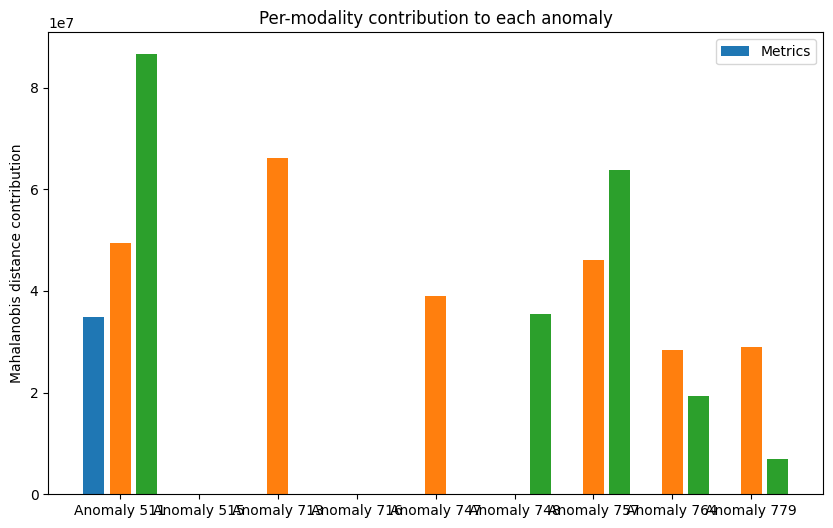

Anomaly 511: Metrics=34930195.9307, Logs=49409063.3398, Traces=86544493.1658
Anomaly 515: Metrics=nan, Logs=nan, Traces=nan
Anomaly 713: Metrics=nan, Logs=66188078.9034, Traces=nan
Anomaly 716: Metrics=nan, Logs=nan, Traces=nan
Anomaly 747: Metrics=nan, Logs=39077931.6385, Traces=nan
Anomaly 748: Metrics=nan, Logs=nan, Traces=35386246.1864
Anomaly 757: Metrics=nan, Logs=46058743.3450, Traces=63821070.4619
Anomaly 764: Metrics=nan, Logs=28457421.2448, Traces=19293828.3988
Anomaly 779: Metrics=nan, Logs=29054382.7939, Traces=7024849.7678


In [ ]:

# Assuming fused_embeddings_np shape: (num_points, 1152)
# and that each modality is 384-dim
mod_dim = 384

metrics_idx = slice(0, mod_dim)
logs_idx    = slice(mod_dim, 2*mod_dim)
traces_idx  = slice(2*mod_dim, 3*mod_dim)

# Function to compute Mahalanobis distance for a subset of dimensions
def mahalanobis_subvector(x, mean, cov_inv, idx):
    sub_x = x[idx]
    sub_mean = mean[idx]
    sub_cov_inv = cov_inv[np.ix_(range(idx.start, idx.stop), range(idx.start, idx.stop))]
    from scipy.spatial.distance import mahalanobis
    return mahalanobis(sub_x, sub_mean, sub_cov_inv)

# Compute per-modality contributions for top anomalies
top_anomalies = anomalies_idx  # indices from previous step
contribs = []

for idx in top_anomalies:
    x = fused_embeddings_np[idx]
    m_dist = mahalanobis_subvector(x, mean_vector, cov_inv, metrics_idx)
    l_dist = mahalanobis_subvector(x, mean_vector, cov_inv, logs_idx)
    t_dist = mahalanobis_subvector(x, mean_vector, cov_inv, traces_idx)
    contribs.append([m_dist, l_dist, t_dist])

contribs = np.array(contribs)  # shape: (num_anomalies, 3)

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_anomalies)*3), contribs.flatten(), color=['C0','C1','C2']*len(top_anomalies))
plt.xticks(np.arange(len(top_anomalies))*3 + 1, [f"Anomaly {i}" for i in top_anomalies])
plt.ylabel("Mahalanobis distance contribution")
plt.legend(["Metrics", "Logs", "Traces"])
plt.title("Per-modality contribution to each anomaly")
plt.show()

# Optional: print the contributions numerically
for i, idx in enumerate(top_anomalies):
    print(f"Anomaly {idx}: Metrics={contribs[i,0]:.4f}, Logs={contribs[i,1]:.4f}, Traces={contribs[i,2]:.4f}")

In [ ]:
print("NaNs in fused embeddings:", np.isnan(fused_embeddings_np).sum())
print("Infs in fused embeddings:", np.isinf(fused_embeddings_np).sum())

NaNs in fused embeddings: 0
Infs in fused embeddings: 0


In [ ]:
eps = 1e-5
cov_matrix = np.cov(fused_embeddings_np, rowvar=False)
cov_matrix += np.eye(cov_matrix.shape[0]) * eps  # regularization
cov_inv = np.linalg.inv(cov_matrix)

In [ ]:
def safe_cov_inv(x):
    cov = np.cov(x, rowvar=False)
    cov += np.eye(cov.shape[0]) * 1e-5
    return np.linalg.inv(cov)
metrics_cov_inv = safe_cov_inv(fused_embeddings_np[:, metrics_idx])
logs_cov_inv    = safe_cov_inv(fused_embeddings_np[:, logs_idx])
traces_cov_inv  = safe_cov_inv(fused_embeddings_np[:, traces_idx])

Anomaly 821: Metrics=19.69, Logs=12.48, Traces=13.86
Anomaly 820: Metrics=17.69, Logs=11.60, Traces=11.95
Anomaly 712: Metrics=15.93, Logs=12.25, Traces=11.72
Anomaly 823: Metrics=13.41, Logs=10.61, Traces=10.58
Anomaly 824: Metrics=12.84, Logs=9.95, Traces=9.02
Anomaly 822: Metrics=12.58, Logs=9.12, Traces=8.85
Anomaly 718: Metrics=12.71, Logs=7.73, Traces=8.13
Anomaly 719: Metrics=11.86, Logs=7.53, Traces=7.51
Anomaly 704: Metrics=11.15, Logs=9.46, Traces=10.13
Anomaly 330: Metrics=8.52, Logs=11.36, Traces=8.17


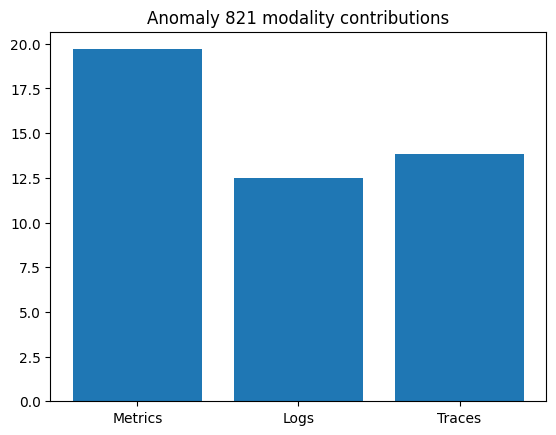

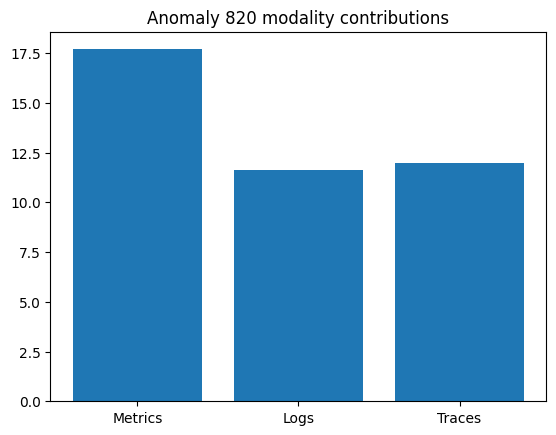

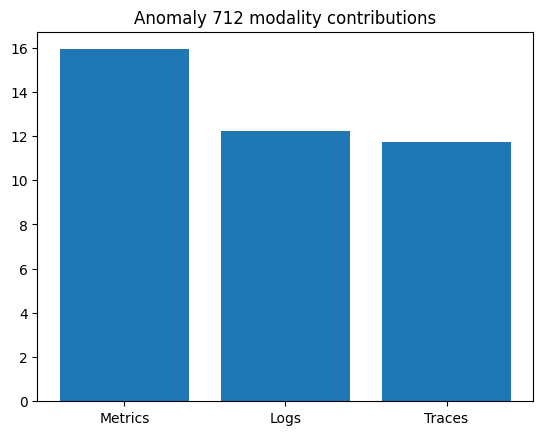

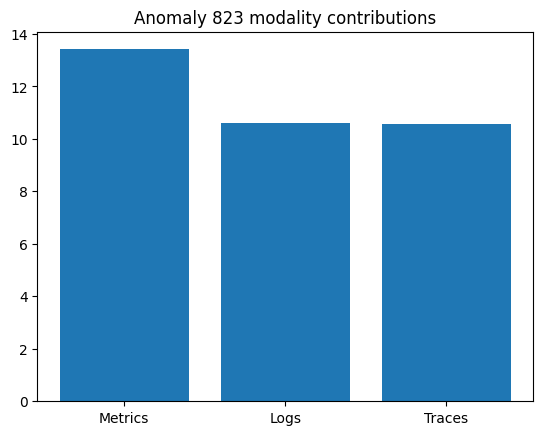

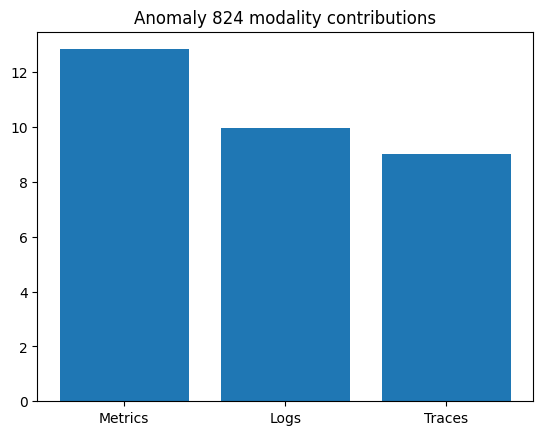

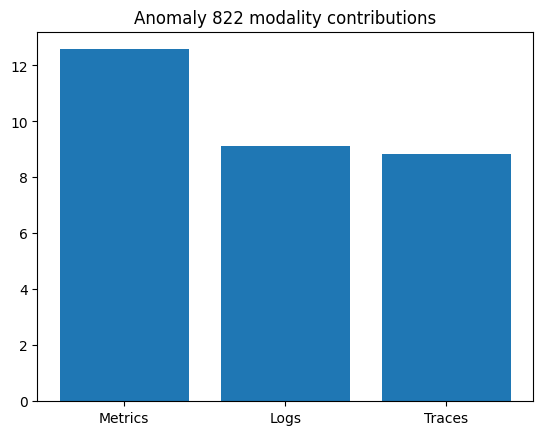

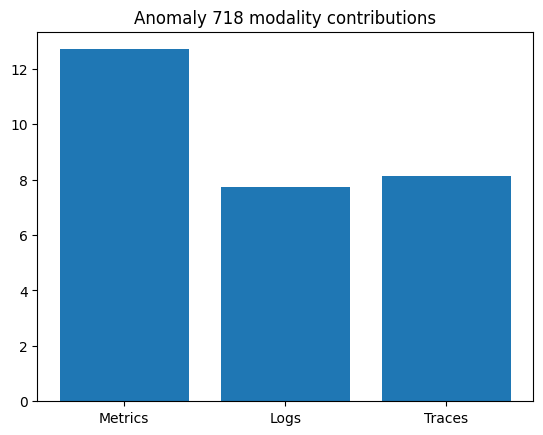

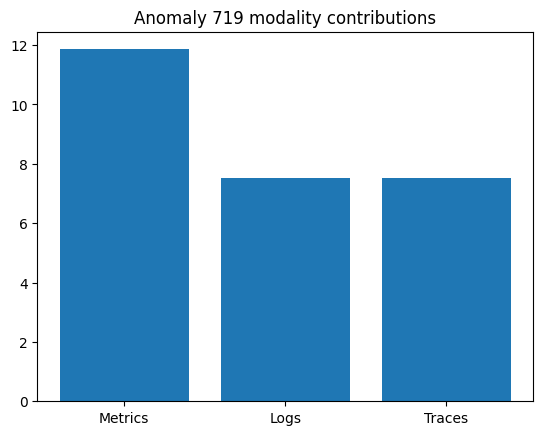

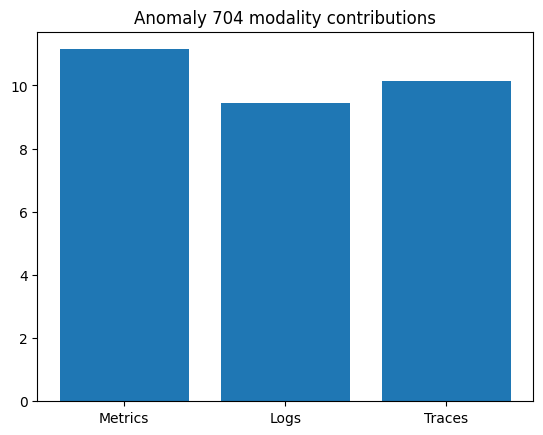

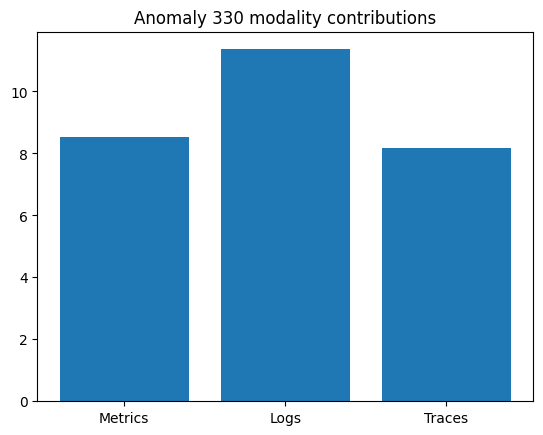

In [ ]:


# Assuming fused_embeddings_np shape: (num_points, total_embed_dim)
# And modality slices:
metrics_idx = slice(0, 384)
logs_idx    = slice(384, 768)
traces_idx  = slice(768, 1152)

def safe_mahalanobis(x):
    """
    Compute Mahalanobis distances with regularization to avoid NaNs.
    x: (num_points, embed_dim)
    """
    mean = np.mean(x, axis=0)
    cov = np.cov(x, rowvar=False)
    # Regularize covariance
    eps = 1e-5
    cov += np.eye(cov.shape[0]) * eps
    cov_inv = np.linalg.inv(cov)
    diff = x - mean
    md = np.sqrt(np.sum(diff @ cov_inv * diff, axis=1))
    return md

metrics_md = safe_mahalanobis(fused_embeddings_np[:, metrics_idx])
logs_md    = safe_mahalanobis(fused_embeddings_np[:, logs_idx])
traces_md  = safe_mahalanobis(fused_embeddings_np[:, traces_idx])

# Total Mahalanobis distance (joint)
joint_md = safe_mahalanobis(fused_embeddings_np)

# Visualize contributions
import matplotlib.pyplot as plt

top_anomalies = joint_md.argsort()[-10:][::-1]

for idx in top_anomalies:
    print(f"Anomaly {idx}: Metrics={metrics_md[idx]:.2f}, Logs={logs_md[idx]:.2f}, Traces={traces_md[idx]:.2f}")

# Optional: bar plot of contributions
for idx in top_anomalies:
    plt.bar(['Metrics','Logs','Traces'], [metrics_md[idx], logs_md[idx], traces_md[idx]])
    plt.title(f"Anomaly {idx} modality contributions")
    plt.show()

In [ ]:


# fused_embeddings: torch.Tensor of shape (num_points, total_embed_dim)
fused_np = fused_embeddings.cpu().numpy()

# Compute learned joint pattern (mean & covariance)
learned_mean = fused_np.mean(axis=0)          # shape: (total_embed_dim,)
learned_cov  = np.cov(fused_np, rowvar=False) # shape: (total_embed_dim, total_embed_dim)

# Compute Mahalanobis distances for anomaly detection
from scipy.spatial.distance import mahalanobis
inv_cov = np.linalg.pinv(learned_cov)

mahal_dist = np.array([mahalanobis(x, learned_mean, inv_cov) for x in fused_np])

# Select top anomalies (example: top 10)
top_idx = np.argsort(mahal_dist)[-10:]

# Compute per-modality contributions
num_modalities = 3
embed_dim_per_mod = fused_embeddings.shape[1] // num_modalities

anom_embeds = fused_np[top_idx]

contribs = []
for i in range(num_modalities):
    start = i * embed_dim_per_mod
    end   = (i+1) * embed_dim_per_mod
    dev = anom_embeds[:, start:end] - learned_mean[start:end]
    modality_contrib = np.linalg.norm(dev, axis=1)**2
    contribs.append(modality_contrib)

contribs = np.stack(contribs, axis=1)
normalized_contribs = contribs / contribs.sum(axis=1, keepdims=True)

import pandas as pd
df_contrib = pd.DataFrame(normalized_contribs, columns=['Metrics','Logs','Traces'], index=top_idx)
print(df_contrib)

      Metrics      Logs    Traces
363  0.582441  0.289290  0.128268
120  0.679219  0.197461  0.123320
108  0.723168  0.139967  0.136865
58   0.725336  0.145058  0.129605
176  0.565189  0.297029  0.137781
791  0.725351  0.124787  0.149862
491  0.740302  0.132737  0.126961
49   0.729318  0.131016  0.139665
526  0.647314  0.209639  0.143047
504  0.559551  0.292087  0.148362



The table shows, for each of the top anomalies, how much Metrics, Logs,
and Traces contributed to the anomaly score, normalized so the contributions sum to 1.

Examples:
- Row 108 - 72% Metrics, 14% Logs, 14% Traces - anomaly is mostly driven by metric deviations.
- Row 363 - 58% Metrics, 29% Logs, 13% Traces - metrics are still dominant, but logs are also significant.


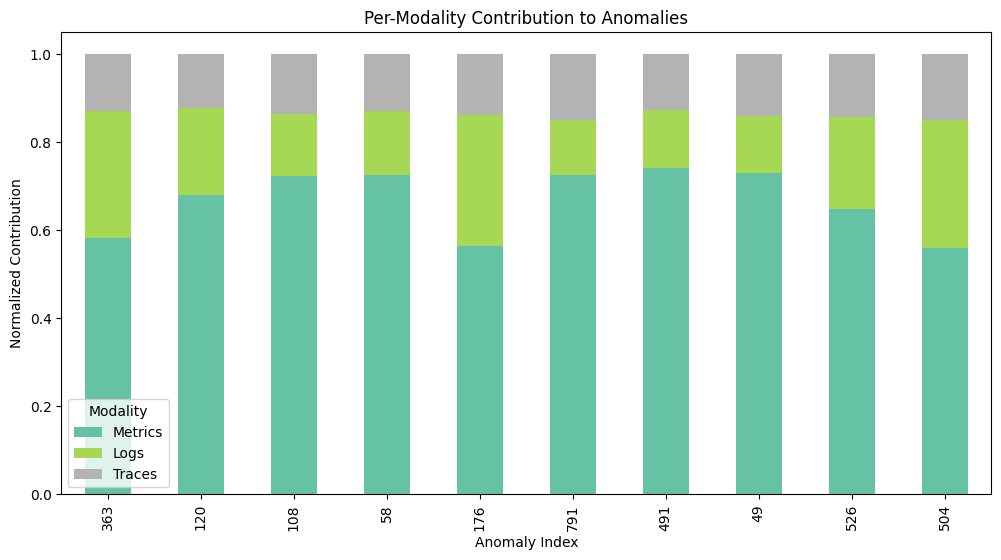

In [ ]:

df_contrib.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set2')
plt.ylabel("Normalized Contribution")
plt.xlabel("Anomaly Index")
plt.title("Per-Modality Contribution to Anomalies")
plt.legend(title="Modality")
plt.show()

In [ ]:
embed_dim_per_mod = 384

metrics_emb = fused_embeddings[:, :embed_dim_per_mod]
logs_emb    = fused_embeddings[:, embed_dim_per_mod:2*embed_dim_per_mod]
traces_emb  = fused_embeddings[:, 2*embed_dim_per_mod:]

In [ ]:


# anomaly index in fused embeddings
anom_idx = 108  # example

# deviation from learned mean (learned_mean should be of shape [1152])
metrics_dev = metrics_emb[anom_idx] - learned_mean[:embed_dim_per_mod]
logs_dev    = logs_emb[anom_idx]    - learned_mean[embed_dim_per_mod:2*embed_dim_per_mod]
traces_dev  = traces_emb[anom_idx]  - learned_mean[2*embed_dim_per_mod:]

# convert to L2 norm per feature (optional: can also use squared deviations)
metrics_feature_scores = metrics_dev.cpu().numpy()
logs_feature_scores    = logs_dev.cpu().numpy()
traces_feature_scores  = traces_dev.cpu().numpy()

/tmp/ipython-input-739073333.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  metrics_dev = metrics_emb[anom_idx] - learned_mean[:embed_dim_per_mod]
/tmp/ipython-input-739073333.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  logs_dev    = logs_emb[anom_idx]    - learned_mean[embed_dim_per_mod:2*embed_dim_per_mod]
/tmp/ipython-input-739073333.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  traces_dev  = traces_emb[anom_idx]  - learned_mean[2*embed_dim_per_mod:]


In [ ]:
metric_cols = ['cpu.user', 'mem.used', 'load.cpucore', 'load.min1', 'load.min5', 'load.min15']
log_cols = ['Payload']  # or more if you combined multiple fields
trace_cols = ['operation', 'Service', 'Project', 'Name']

# assuming embeddings correspond to features in order (approximate)
metrics_scores_df = pd.DataFrame([metrics_feature_scores[:len(metric_cols)]], columns=metric_cols)
logs_scores_df    = pd.DataFrame([logs_feature_scores[:len(log_cols)]], columns=log_cols)
traces_scores_df  = pd.DataFrame([traces_feature_scores[:len(trace_cols)]], columns=trace_cols)

In [ ]:
anom_feature_scores = pd.concat([metrics_scores_df, logs_scores_df, traces_scores_df], axis=1)
print(anom_feature_scores)

   cpu.user  mem.used  load.cpucore  load.min1  load.min5  load.min15  \
0 -0.004714 -0.005638      0.000819   0.006835   0.003535    0.002325   

    Payload  operation   Service   Project      Name  
0 -0.000018  -0.002019 -0.000367 -0.005035 -0.001039  


/tmp/ipython-input-205845008.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  metrics_dev = metrics_emb[idx] - learned_mean[:embed_dim_per_mod]
/tmp/ipython-input-205845008.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  logs_dev    = logs_emb[idx]    - learned_mean[embed_dim_per_mod:2*embed_dim_per_mod]
/tmp/ipython-input-205845008.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  traces_dev  = traces_emb[idx]  - learned_mean[2*embed_dim_per_mod:]


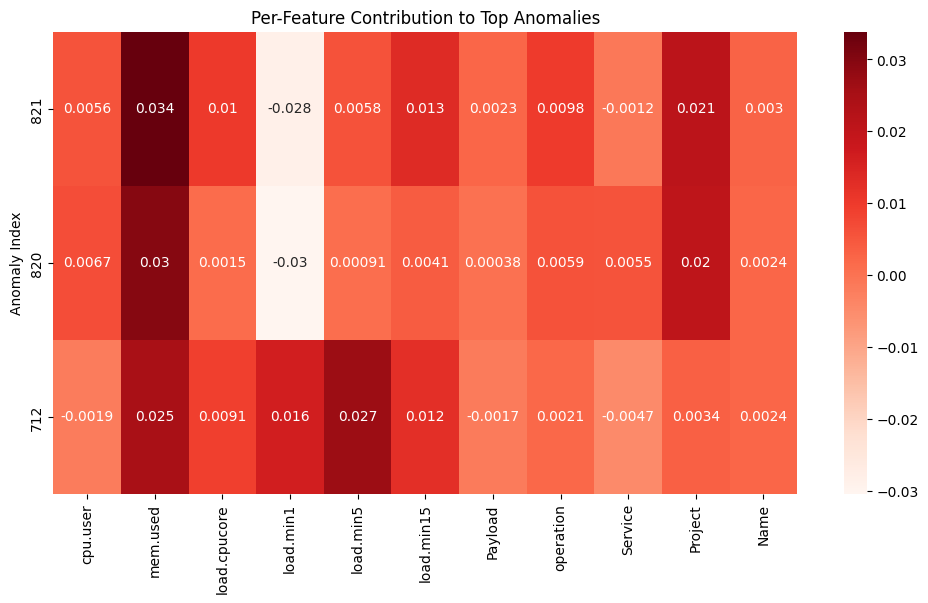

In [ ]:


top_indices = [821, 820, 712]  # your detected anomalies
all_scores = []

for idx in top_indices:
    metrics_dev = metrics_emb[idx] - learned_mean[:embed_dim_per_mod]
    logs_dev    = logs_emb[idx]    - learned_mean[embed_dim_per_mod:2*embed_dim_per_mod]
    traces_dev  = traces_emb[idx]  - learned_mean[2*embed_dim_per_mod:]

    scores = np.concatenate([
        metrics_dev.cpu().numpy()[:len(metric_cols)],
        logs_dev.cpu().numpy()[:len(log_cols)],
        traces_dev.cpu().numpy()[:len(trace_cols)]
    ])
    all_scores.append(scores)

feature_names = metric_cols + log_cols + trace_cols
heatmap_df = pd.DataFrame(all_scores, columns=feature_names, index=top_indices)

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_df, annot=True, cmap='Reds')
plt.title("Per-Feature Contribution to Top Anomalies")
plt.ylabel("Anomaly Index")
plt.show()

In [ ]:
top_idx  # or
top_anomalies

array([821, 820, 712, 823, 824, 822, 718, 719, 704, 330])

In [ ]:
traces_df = traces

In [ ]:
error_anomalies = [idx for idx in anomalous_indices if logs_df.iloc[idx]['log_level'] == 'ERROR']
print(error_anomalies)

[]



The anomalies we found do not coincide with log_level == "error" (case-insensitive).

Next step:
Run another model using supervised learning with errors as the target.



In [ ]:
# Prepare the target

# Make log_level lowercase
logs_df['log_level_lower'] = logs_df['log_level'].str.lower()

# Target: 1 if error, else 0
y = (logs_df['log_level_lower'] == 'error').astype(int).values

# Make sure y aligns with your embeddings
print(f"Target shape: {y.shape}, Sample distribution:\n{np.bincount(y)}")

Target shape: (105533,), Sample distribution:
[105508     25]


In [ ]:
# Combine embeddings into features



# Make sure embeddings are the same length as y
min_len = min(len(log_embeddings), len(trace_embeddings), len(metrics_embeddings), len(y))
X = torch.cat([
    metrics_embeddings[:min_len],
    log_embeddings[:min_len],
    trace_embeddings[:min_len]
], dim=1)

y = y[:min_len]

print(f"Feature shape: {X.shape}, Target shape: {y.shape}")

Feature shape: torch.Size([105533, 1152]), Target shape: (105533,)


In [ ]:
# Train a simple classifier (e.g., MLP)


# Dataset & loader
dataset = TensorDataset(X, torch.tensor(y, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=512, shuffle=True)

# Simple MLP
class SupervisedMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Binary classification
        )

    def forward(self, x):
        return self.net(x)

model = SupervisedMLP(input_dim=X.shape[1]).to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Training loop

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(dataset):.6f}")

Epoch 1/10 | Loss: 0.023948
Epoch 2/10 | Loss: 0.001897
Epoch 3/10 | Loss: 0.001533
Epoch 4/10 | Loss: 0.000905
Epoch 5/10 | Loss: 0.000418
Epoch 6/10 | Loss: 0.000121
Epoch 7/10 | Loss: 0.000068
Epoch 8/10 | Loss: 0.000034
Epoch 9/10 | Loss: 0.000013
Epoch 10/10 | Loss: 0.000010


In [ ]:
# Evaluation

model.eval()
with torch.no_grad():
    preds = model(X.to(device)).cpu().numpy()
    pred_labels = (preds > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y, pred_labels))
print(confusion_matrix(y, pred_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105508
           1       1.00      1.00      1.00        25

    accuracy                           1.00    105533
   macro avg       1.00      1.00      1.00    105533
weighted avg       1.00      1.00      1.00    105533

[[105508      0]
 [     0     25]]


In [ ]:


# Parameters

embed_dim_per_mod = 384
modalities = ['Metrics', 'Logs', 'Traces']
top_k = 5  # for contribution analysis
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:


device = "cuda" if torch.cuda.is_available() else "cpu"

# Ensure embeddings are on CPU (or move to GPU if needed)
metrics_embeddings_full = metrics_embeddings.to(device)
log_embeddings_full     = log_embeddings.to(device)
trace_embeddings_full   = trace_embeddings.to(device)

# Cross-attention fusion model (reuse your fusion_model)
fusion_model.to(device)
fusion_model.eval()  # no gradients needed

batch_size = 1024  # adjust to fit memory
fused_embeddings_full_list = []

num_samples = log_embeddings_full.shape[0]  # should match log labels
for i in tqdm(range(0, num_samples, batch_size), desc="Fusing all embeddings"):
    metrics_batch = metrics_embeddings_full[i:i+batch_size]
    logs_batch    = log_embeddings_full[i:i+batch_size]
    traces_batch  = trace_embeddings_full[i:i+batch_size]

    # Forward pass
    with torch.no_grad():
        fused = fusion_model(metrics_batch, logs_batch, traces_batch)  # shape: (batch, total_embed_dim)
        fused_embeddings_full_list.append(fused.cpu())

# Concatenate all batches
fused_embeddings_full = torch.cat(fused_embeddings_full_list, dim=0)
print(f"Full fused embeddings shape: {fused_embeddings_full.shape}")

# Save for future use
torch.save(fused_embeddings_full, "/content/fused_embeddings_full.pt")

Fusing all embeddings: 100%|██████████| 104/104 [00:52<00:00,  1.97it/s]

Full fused embeddings shape: torch.Size([104, 1152])


In [ ]:


# Load your logs if not already
logs_df = pd.read_csv("/content/logs.csv")

# Create binary labels (1 if log_level == 'error', case-insensitive)
logs_df['log_level'] = logs_df['log_level'].str.lower()  # ensure lowercase
log_level_labels = (logs_df['log_level'] == 'error').astype(int).values  # 0/1 array

print(f"Target shape: {log_level_labels.shape}, Sample distribution:\n{pd.Series(log_level_labels).value_counts()}")

# Convert to torch tensor if needed
log_level_labels = torch.tensor(log_level_labels, dtype=torch.float32)

Target shape: (105533,), Sample distribution:
0    105508
1        25
Name: count, dtype: int64


In [ ]:
# Convert timestamp columns to pandas datetime
metrics_df['now'] = pd.to_datetime(metrics_df['now'], errors='coerce')
traces_df['Timestamp'] = pd.to_datetime(traces_df['Timestamp'], errors='coerce')
logs_df['Timestamp'] = pd.to_datetime(logs_df['Timestamp'], errors='coerce')

# Then run the aggregation
metrics_emb_per_log = aggregate_to_logs(metrics_emb, metrics_df['now'], logs_df['Timestamp'])
trace_emb_per_log   = aggregate_to_logs(trace_emb, traces_df['Timestamp'], logs_df['Timestamp'])

IndexError: The shape of the mask [214759] at index 0 does not match the shape of the indexed tensor [214699, 384] at index 0

In [ ]:
# Keep only the rows that were actually embedded
metrics_df_emb = metrics_df.iloc[seq_len-1:].reset_index(drop=True)  # matches metrics_seq used for embedding

NameError: name 'seq_len' is not defined